In [58]:
%load_ext autoreload
%autoreload 2
import chess
import chess.engine
from collections import defaultdict
import random
import numpy as np
from sarfa_core import computeSaliencyUsingSarfa
from sys import platform as _platform
from utils import get_all_pos, get_move_obj
from utils import pos_to_index_mapping
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import Image, display
import cairosvg
import cv2
import svg_custom.svg_custom as svg_custom 
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import entropy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## General Purpose Functions - Perturbations and Q-Values

In [55]:
def get_engine(engine_file = './stockfish_15_x64_avx2'):
    """
    Generate chess engine object
    """
    chess_engine = chess.engine.SimpleEngine.popen_uci(engine_file)
    return chess_engine

def q_values(board, candidate_actions, selected_action, multipv=3, runtime=2.0, use_optimal_action=False):
    """
    Compute the q-values Q(s,a) for a given board
    """

    options = chess_engine.analyse(board, chess.engine.Limit(time=runtime), multipv=multipv)
    
    score_per_move = defaultdict(int)

    for option in options:
        is_white_move = option['score'].turn
        score = option['score'].white() if is_white_move else option['score'].black()
        
        curr_action = str(option["pv"][0])
        if option['score'].is_mate():
            score = 40 if '+' in str(score) else -40
        else:
            score = round(score.cp/100.0, 2)
        
        score_per_move[curr_action] = score

    q_vals = {}
    optimal_action = None
    best_q_val = float('-inf')
    for valid_move in candidate_actions:
        q_vals[str(valid_move)] = score_per_move[str(valid_move)]

        if q_vals[str(valid_move)] > best_q_val:
            best_q_val = q_vals[str(valid_move)]
            optimal_action = str(valid_move)
        
    if use_optimal_action:
        selected_action = optimal_action

    return q_vals, selected_action

In [4]:
def removal_perturb(board, position):
    """
    Preturb the board by removing the piece from the chosen position if possible
    """

    position = get_move_obj(position)
    piece = board.piece_at(position)
    if not piece or piece == chess.Piece(chess.KING, chess.WHITE) or piece == chess.Piece(chess.KING, chess.BLACK):
        return
    
    perturbed_board = board.copy()
    perturbed_board.remove_piece_at(position)
    if perturbed_board.was_into_check():
        return 
    
    return [perturbed_board], position

def empty_space_perturb(board, position):
    """
    Preturb the board by adding a pawn (of same color) to empty position if possible
    """

    position = get_move_obj(position)
    piece = board.piece_at(position)
    if not piece:
        perturbed_board = board.copy()
        new_piece = chess.Piece(chess.PAWN, chess.WHITE) if board.turn else chess.Piece(chess.PAWN, chess.BLACK)
        perturbed_board.set_piece_at(position, new_piece)
        if perturbed_board.was_into_check():
            return
        
        return [perturbed_board], position
    else:
        return

# def opp_piece_perturb(board, position):
#     position = get_move_obj(position)
#     piece = board.piece_at(position)
#     if not piece:
#         return
    
#     if piece.color and board.turn:
        
    
    

In [56]:
def visualize_directed_graph(graph):
    """
    Visualize a directed graph
    """

    G = nx.DiGraph()
    
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    plt.figure(figsize=(4, 4))
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=75, font_size=6, font_weight='bold', edge_color='gray', arrows=True)

    edge_labels = {edge: '' for edge in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Directed Graph Visualization")
    plt.show()

## Empty Space Perturbations

In [63]:
def generate_heatmap(board, perturbation_to_saliency, bestmove):
    """
    Generates heatmap for saliency evaluation of the best move
    """
    # Laying the saliency map over the board
    heatmap = np.zeros((8, 8))
    for position in perturbation_to_saliency:
        row, col = pos_to_index_mapping(position)
        heatmap[row, col] = perturbation_to_saliency[position]

    heatmap = np.flipud(heatmap)
    # print(heatmap)
    
    #### Saliency map overlaid on board
    bestmove = chess.Move.from_uci(bestmove)
    svg = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600')])

    with open('svg_custom/board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='svg_custom/board.svg', write_to='svg_custom/board.png')

    # original board as a numpy array
    board_array = cv2.imread('svg_custom/board.png')

    threshold = (100/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)

    cv2.imwrite("svg_custom/board.png", board_array)
    print('------------===============------------===============\n\n')
    display(Image('svg_custom/board.png'))
    print('\n\n------------===============------------===============')

In [60]:
#########################################
num_actions = 100
runtime = 1.5
use_optimal_action = True
allow_defense = False

# Bishop Pins Rooks
# FEN = "5rk1/6pp/1B1r4/5p2/8/2P5/PP6/1K4R1 w - - 0 1"
# action = "b6c5"

# Bishop Checks on Open Diagonal - showcases empty space perturbation
# FEN = "6N1/1pkb4/p3pQ1p/2P1P3/3P4/4q1P1/PP5P/5R1K b - - 0 33"
# action = "d7c6"

# Backrank Check protected by Knight - identifying defensive pieces?
# FEN = "6k1/1n3ppp/8/8/8/8/7P/1K1R4 w - - 0 1"
# action = "d1d8"

# More complicated Backrank Check - identify defensive pieces
# FEN = "3r2kr/5ppp/8/1n6/3B3R/8/1PP4P/RK6 b - - 0 1"
# action = "d8d4"

# Example from SARFA paper - testing relationships
# FEN = '3r1rk1/1b2bpp1/p3p2p/R3N3/2pB1P2/2P3qP/PP1Q2P1/5RK1 b - - 0 1'
# action = 'd8d4'

# Random Complicated Position
FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
action = ''
#########################################

chess_engine = get_engine()
board = chess.Board(FEN)
legal_moves = set(list(board.legal_moves))
perturbation_to_qvals = dict()
perturbation_to_saliency = dict()

optimal_move_original_board = None

board_positions = get_all_pos()
for pos in board_positions:
    # can substitute for any perturb function
    # perturbed_state = removal_perturb(board, pos)
    perturbed_state = empty_space_perturb(board, pos)
    if perturbed_state is None:
        continue

    perturbed_boards, _ = perturbed_state

    # list of perturbed boards allows for perturb function to test different 
    # perturbations on the same state
    for i, perturbed_board in enumerate(perturbed_boards):
        new_legal_moves = perturbed_board.legal_moves
        candidate_actions = legal_moves.intersection(set(new_legal_moves))

        if not use_optimal_action and chess.Move.from_uci(action) not in candidate_actions:
            continue
        
        q_vals_before, selected_action = q_values(board, candidate_actions, action, multipv=num_actions, 
                                            runtime=runtime, use_optimal_action=use_optimal_action)

        optimal_move_original_board = selected_action

        q_vals_after, selected_action = q_values(perturbed_board, candidate_actions, selected_action, 
                                            multipv=num_actions, runtime=runtime)
    
        saliency, dP, K, QmaxAnswer, _, _ = computeSaliencyUsingSarfa(selected_action, q_vals_before, q_vals_after, allow_defense_check=allow_defense)
        saliency = 0 if abs(saliency) < 0.001 else saliency

        saliency_type = ""
        if allow_defense and dP < 0 and abs(dP) > 0.1:
            saliency_type = "Defensive "
            saliency = abs(saliency)
        
        perturbation_to_saliency[pos] = abs(saliency)
        perturbation_to_qvals[pos] = [q_vals_before, q_vals_after]
        print(f'Perturbed Board {i}, Perturbed position: {pos}, Action: {selected_action}, Saliency Type: {saliency_type}, Saliency: {saliency}')


Perturbed Board 0, Perturbed position: a1, Action: d3d8, Saliency Type: , Saliency: 0
Perturbed Board 0, Perturbed position: a4, Action: d3d6, Saliency Type: , Saliency: 0.07335616788051065
Perturbed Board 0, Perturbed position: a5, Action: d3d6, Saliency Type: , Saliency: 0.1133428590542397
Perturbed Board 0, Perturbed position: a7, Action: d3d6, Saliency Type: , Saliency: 0.17366991009479912
Perturbed Board 0, Perturbed position: a8, Action: d3d8, Saliency Type: , Saliency: 0.12471030631300309
Perturbed Board 0, Perturbed position: b1, Action: d3d8, Saliency Type: , Saliency: 0.13072923752729576
Perturbed Board 0, Perturbed position: b2, Action: d3d6, Saliency Type: , Saliency: 0.39773847548885194
Perturbed Board 0, Perturbed position: b5, Action: d3d8, Saliency Type: , Saliency: 0
Perturbed Board 0, Perturbed position: b6, Action: d3d6, Saliency Type: , Saliency: 0
Perturbed Board 0, Perturbed position: b7, Action: d3d6, Saliency Type: , Saliency: 0.0906747694571459
Perturbed Board 

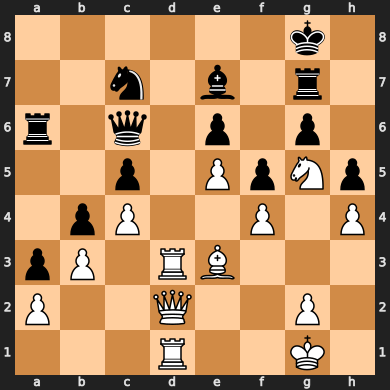

In [64]:
board

------------===============------------===============




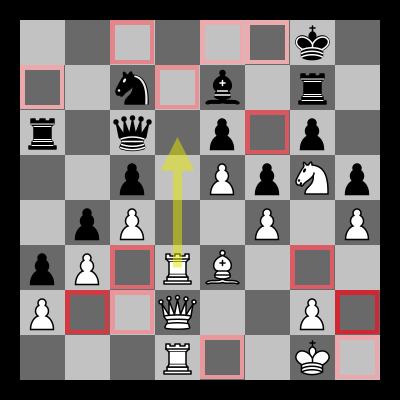



------------===============------------===============


In [65]:
generate_heatmap(board, perturbation_to_saliency, optimal_move_original_board)

## Offensive + Defensive Saliency (SARFA Extension)

In [75]:
def generate_heatmap_offense_defense(board, perturbation_to_saliency, bestmove):
    """
    Generates heatmap for saliency evaluation of the best move
    """
    # Laying the saliency map over the board
    heatmap = np.zeros((8, 8))
    # +1=offense, -1=defense
    offense_defense_heatmap = np.zeros((8, 8))
    for position in perturbation_to_saliency:
        row, col = pos_to_index_mapping(position)
        heatmap[row, col] = perturbation_to_saliency[position][1]
        if (perturbation_to_saliency[position][0] == 'defensive'):
            offense_defense_heatmap[row, col] = -1
        else:
            offense_defense_heatmap[row, col] = 1

    heatmap = np.flipud(heatmap)
    offense_defense_heatmap = np.flipud(offense_defense_heatmap)
    
    #### Saliency map overlaid on board
    bestmove = chess.Move.from_uci(bestmove)
    svg = svg_custom.board(board, arrows = [svg_custom.Arrow(tail =  bestmove.from_square, head = bestmove.to_square, color = '#e6e600')])

    with open('svg_custom/board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='svg_custom/board.svg', write_to='svg_custom/board.png')

    # original board as a numpy array
    board_array = cv2.imread('svg_custom/board.png')

    threshold = (100/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    # offensive
                    if (int(offense_defense_heatmap[i, j]) == 1):
                        board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                        board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                        board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                    else:
                        # defensive
                        board_array[box_i, box_j, 0] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                        board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)
                        board_array[box_i, box_j, 2] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap) + 1e-10)

    cv2.imwrite("svg_custom/board.png", board_array)
    print('------------===============------------===============\n\n')
    display(Image('svg_custom/board.png'))
    print('\n\n------------===============------------===============')

In [76]:
#########################################
num_actions = 100
runtime = 3
use_optimal_action = True
allow_defense = True

# Bishop Pins Rooks
# FEN = "5rk1/6pp/1B1r4/5p2/8/2P5/PP6/1K4R1 w - - 0 1"
# action = "b6c5"

# Bishop Checks on Open Diagonal - showcases empty space perturbation
# FEN = "6N1/1pkb4/p3pQ1p/2P1P3/3P4/4q1P1/PP5P/5R1K b - - 0 33"
# action = "d7c6"

# Backrank Check protected by Knight - identifying defensive pieces?
# FEN = "6k1/1n3ppp/8/8/8/8/7P/1K1R4 w - - 0 1"
# action = "d1d8"

# More complicated Backrank Check - identify defensive pieces
# FEN = "3r2kr/5ppp/8/1n6/3B3R/8/1PP4P/RK6 b - - 0 1"
# action = "d8d4"

# Example from SARFA paper - testing relationships
# FEN = '3r1rk1/1b2bpp1/p3p2p/R3N3/2pB1P2/2P3qP/PP1Q2P1/5RK1 b - - 0 1'
# action = 'd8d4'

# Random Complicated Position
FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
action = ''
#########################################


chess_engine = get_engine()
board = chess.Board(FEN)
legal_moves = set(list(board.legal_moves))
perturbation_to_qvals = dict()
perturbation_to_saliency = dict()

optimal_move_original_board = None

board_positions = get_all_pos()
for pos in board_positions:
    # can substitute for any perturb function
    perturbed_state = removal_perturb(board, pos)

    if perturbed_state is None:
        continue

    perturbed_boards, _ = perturbed_state

    # list of perturbed boards allows for perturb function to test different 
    # perturbations on the same state
    for i, perturbed_board in enumerate(perturbed_boards):
        new_legal_moves = perturbed_board.legal_moves
        candidate_actions = legal_moves.intersection(set(new_legal_moves))

        if not use_optimal_action and chess.Move.from_uci(action) not in candidate_actions:
            continue
        
        q_vals_before, selected_action = q_values(board, candidate_actions, action, multipv=num_actions, 
                                            runtime=runtime, use_optimal_action=use_optimal_action)

        optimal_move_original_board = selected_action

        q_vals_after, selected_action = q_values(perturbed_board, candidate_actions, selected_action, 
                                            multipv=num_actions, runtime=runtime)
    
        saliency, dP, K, QmaxAnswer, _, _ = computeSaliencyUsingSarfa(selected_action, q_vals_before, q_vals_after, allow_defense_check=allow_defense)
        saliency = 0 if abs(saliency) < 0.001 else saliency

        saliency_type = ""
        if allow_defense and dP < 0 and abs(dP) > 0.1:
            saliency_type = "defensive"
            saliency = abs(saliency)
        else:
            saliency_type = "offensive"
        
        perturbation_to_saliency[pos] = [saliency_type, abs(saliency)]
        perturbation_to_qvals[pos] = [q_vals_before, q_vals_after]
        print(f'Perturbed Board {i}, Perturbed position: {pos}, Action: {selected_action}, Saliency Type: {saliency_type}, Saliency: {saliency}')


Perturbed Board 0, Perturbed position: a2, Action: d3d8, Saliency Type: offensive, Saliency: 0.3659066936344419
Perturbed Board 0, Perturbed position: a3, Action: d3d6, Saliency Type: offensive, Saliency: 0.37984272045363454
Perturbed Board 0, Perturbed position: a6, Action: d3d8, Saliency Type: defensive, Saliency: 7.6140730915347445
Perturbed Board 0, Perturbed position: b3, Action: d3d8, Saliency Type: offensive, Saliency: 0.45925578459508515
Perturbed Board 0, Perturbed position: b4, Action: d3d6, Saliency Type: offensive, Saliency: 0.2716349916509339
Perturbed Board 0, Perturbed position: c4, Action: d3d8, Saliency Type: offensive, Saliency: -0.04252971436388225
Perturbed Board 0, Perturbed position: c5, Action: d3d8, Saliency Type: offensive, Saliency: 0.384702096953337
Perturbed Board 0, Perturbed position: c6, Action: d3d6, Saliency Type: offensive, Saliency: 0.07837721561386798
Perturbed Board 0, Perturbed position: c7, Action: d3d8, Saliency Type: defensive, Saliency: 18.0975

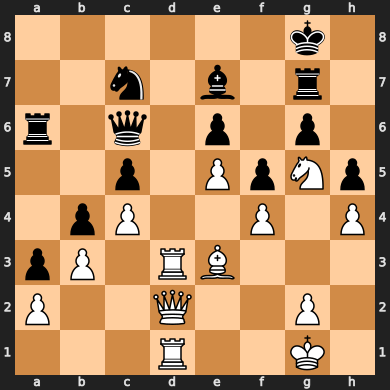

In [77]:
board

red: offensively salient pieces
blue: defensively salient pieces
------------===============------------===============




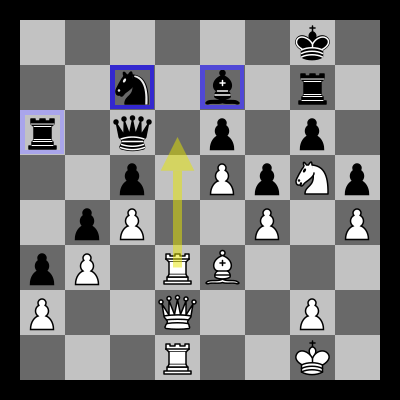



------------===============------------===============


In [78]:
print("red: offensively salient pieces")
print("blue: defensively salient pieces")
generate_heatmap_offense_defense(board, perturbation_to_saliency, optimal_move_original_board)

## Arsh's KL Divergence Grouping Method (Not Using)

In [5]:
def dfs(curr, cluster, graph):
    if curr not in cluster:
        cluster.add(curr)
        for neighbor in graph[curr]:
            dfs(neighbor, cluster, graph)

In [10]:
################################
kD_threshold = 0.3
################################

relationship_graph = defaultdict(set)
directed_graph = defaultdict(set)

# Compute most important pair of pieces for each piece
for pos1 in perturbation_to_qvals.keys():
    q_val_before, q_val_after = perturbation_to_qvals[pos1]
    
    action_dist_before = defaultdict(list)
    action_dist_after = defaultdict(list)
    for action in q_val_before.keys():
        pos2 = action[:2]
        action_dist_before[pos2].append(q_val_before[action])
        action_dist_after[pos2].append(q_val_after[action])
    
    other_positions = []
    kl_divergences = []
    for pos2 in action_dist_before:
        # Softmax
        a_b = action_dist_before[pos2]
        a_b = np.exp(a_b) / np.sum(np.exp(a_b))
        a_b = np.clip(a_b, 1e-10, 1)

        a_a = action_dist_after[pos2]
        a_a = np.exp(a_a) / np.sum(np.exp(a_a))
        a_a = np.clip(a_a, 1e-10, 1)

        # KL-Divergence
        kD = np.sum(a_b * np.log(a_b / a_a))
        kl_divergences.append(kD)
        other_positions.append(pos2)
    
    kl_divergences = np.array(kl_divergences)
    smax_kd = np.exp(kl_divergences) / np.sum(np.exp(kl_divergences))
    max_idx = np.argmax(smax_kd)
    
    # print(pos1 + ":")
    # for j in range(len(smax_kd)):
    #     print("    " + other_positions[j] + " " + str(smax_kd[j]))
    # print("\n")

    if smax_kd[max_idx] > kD_threshold:
        closest_pos = other_positions[max_idx]
        relationship_graph[pos1].add(closest_pos)
        relationship_graph[closest_pos].add(pos1)
        
        directed_graph[closest_pos].add(pos1)

# Run graph traversal to find all connected pieces
visited = set()
for position in perturbation_to_qvals.keys():
    if position not in visited:
        visited.add(position)
        curr_cluster = set()
        dfs(position, curr_cluster, relationship_graph)

        visited = visited.union(curr_cluster)
        
        if len(curr_cluster) > 1:
            print(f'Pieces at these positions are related: {list(curr_cluster)}')
        

Pieces at these positions are related: ['c6', 'd1', 'e5', 'c7', 'e3', 'd3', 'b4', 'e7', 'a2']
Pieces at these positions are related: ['g6', 'g2', 'g5']


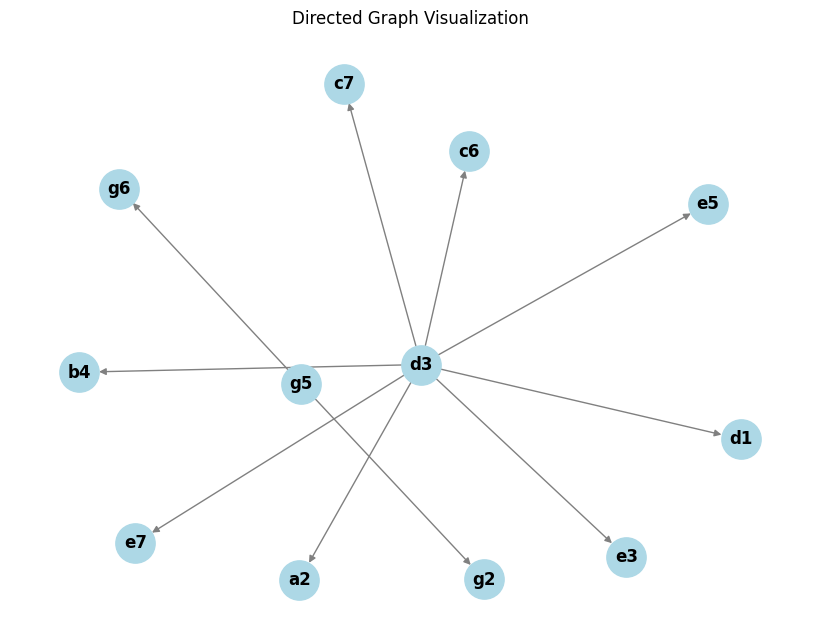

defaultdict(<class 'set'>, {'d3': {'e7', 'c6', 'd1', 'e5', 'e3', 'b4', 'c7', 'a2'}, 'g5': {'g6', 'g2'}})


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_directed_graph(graph):
    G = nx.DiGraph()
    
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, font_weight='bold', edge_color='gray', arrows=True)

    edge_labels = {edge: '' for edge in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Directed Graph Visualization")
    plt.show()

visualize_directed_graph(directed_graph)
print(directed_graph)

## Sequential Pairwise Sensitivity Method

In [8]:
def get_perturbed_q_values(board, num_actions, runtime, use_optimal_action, action):
    """
    Get the before and after perturbation q-values for specific board
    """
    legal_moves = set(list(board.legal_moves))
    perturbation_to_qvals = dict()
    perturbation_to_saliency = dict()

    board_positions = get_all_pos()
    for pos in board_positions:
        # can substitute for any perturb function
        perturbed_state = removal_perturb(board, pos)
        if perturbed_state is None:
            continue

        perturbed_boards, _ = perturbed_state

        # list of perturbed boards allows for perturb function to test different 
        # perturbations on the same state
        for i, perturbed_board in enumerate(perturbed_boards):
            new_legal_moves = perturbed_board.legal_moves
            candidate_actions = legal_moves.intersection(set(new_legal_moves))

            if not use_optimal_action and chess.Move.from_uci(action) not in candidate_actions:
                continue
            
            q_vals_before, selected_action = q_values(board, candidate_actions, action, multipv=num_actions, 
                                                runtime=runtime, use_optimal_action=use_optimal_action)
            q_vals_after, selected_action = q_values(perturbed_board, candidate_actions, selected_action, 
                                                multipv=num_actions, runtime=runtime)
            
            perturbation_to_qvals[pos] = [q_vals_before, q_vals_after]
            # print(f'Perturbed Board {i}, Perturbed position: {pos}, Action: {selected_action}')
    return perturbation_to_qvals, selected_action


In [9]:
def get_pairwise_sensitivity(perturbation_to_qvals, sum_technique, current_to_original_pos_mapping):
    """
    With the perturbed q-values, get the pairwise_sensitivity between all combination of pieces
    """
    pairwise_sensitivity = {}
    all_pieces_removed = perturbation_to_qvals.keys()

    for piece_1 in all_pieces_removed:
        for piece_2 in all_pieces_removed:
            if (piece_1 != piece_2):
                valid_actions_perturb_1 = set(perturbation_to_qvals[piece_1][0].keys())
                valid_actions_perturb_2 = set(perturbation_to_qvals[piece_2][0].keys())
                intersection_actions = valid_actions_perturb_1.intersection(valid_actions_perturb_2)

                curr_sensitivity = 0
                if (sum_technique):
                    # Uses sum technique
                    for action in intersection_actions:
                        delta_1 = perturbation_to_qvals[piece_1][1][action] - perturbation_to_qvals[piece_1][0][action]
                        delta_2 = perturbation_to_qvals[piece_2][1][action] - perturbation_to_qvals[piece_2][0][action]
                        curr_sensitivity += abs(delta_1-delta_2)
                else:
                    # KL divergence technique
                    distribution_1_after = [perturbation_to_qvals[piece_1][1][action] for action in intersection_actions]
                    distribution_2_after = [perturbation_to_qvals[piece_2][1][action] for action in intersection_actions]

                    distribution_1_after = np.array(distribution_1_after)
                    distribution_2_after = np.array(distribution_2_after)

                    distribution_1_after = softmax(distribution_1_after)
                    distribution_2_after = softmax(distribution_2_after)

                    curr_sensitivity = entropy(distribution_1_after, distribution_2_after)
                
                original_piece_1 = current_to_original_pos_mapping[piece_1]
                original_piece_2 = current_to_original_pos_mapping[piece_2]

                pairwise_sensitivity[(original_piece_1, original_piece_2)] = curr_sensitivity

    return pairwise_sensitivity

In [10]:
def get_sequential_pairwise_dependencies(num_actions, runtime, use_optimal_action, sum_technique, discount_factor, depth, FEN, action):
    """
    Get the pairwise_sensitivity between all combination of pieces over depth steps into the future for specific board (FEN).
    """

    chess_engine = get_engine()
    board = chess.Board(FEN)

    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}
    pairwise_sensitivity = None

    for i in range(0, depth):
        print(f'step: {i}')

        perturbation_to_qvals, selected_action = get_perturbed_q_values(board, num_actions, runtime, use_optimal_action, action)
        curr_pairwise_sensitivity = get_pairwise_sensitivity(perturbation_to_qvals, sum_technique, current_to_original_pos_mapping)

        print(f'next action: {selected_action}')

        if (pairwise_sensitivity == None):
            pairwise_sensitivity = curr_pairwise_sensitivity
        else:
            for key, value in curr_pairwise_sensitivity.items():
                if (key in pairwise_sensitivity):
                    pairwise_sensitivity[key] += (((discount_factor)**i) * value)

        # take next optimal move
        optimal_move = chess.Move.from_uci(selected_action)
        board.push(optimal_move)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = selected_action[0:2]
            end_move_pos = selected_action[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break

    return pairwise_sensitivity

In [16]:
def filter_pairwise_sensitivity(pairwise_sensitivity, use_percentile=True, use_topk=False, percentile=10, topk=10):
    """
    Select the most important pairs of pieces (relationships) based off the pairwise sensitivity values.
    """
    if (not use_percentile and not use_topk):
        return None
    pairwise_sensitivity_list = pairwise_sensitivity.items()
    values = [x[1] for x in pairwise_sensitivity_list]

    if (use_percentile):
        bottom_percentile = np.percentile(values, percentile)
        bottom_percentile_pairs = [item[0] for item in pairwise_sensitivity_list if item[1] <= bottom_percentile]
        return bottom_percentile_pairs
    elif (use_topk):
        pairwise_sensitivity_list.sort(key=lambda x: x[1])
        top_k_matches = [item[0] for item in pairwise_sensitivity_list[0:topk]]
        return top_k_matches

In [26]:
def dfs(curr_node, graph, visited_set):
    visited_set.add(curr_node)
    if (curr_node in graph):
        for neighbor in graph[curr_node]:
            if (neighbor not in visited_set):
                dfs(neighbor, graph, visited_set)
    return

In [28]:
def find_groups_important_relationships(most_related_pairs):
    # check if there is any pairs at all
    if (len(most_related_pairs) == 0):
        return None
    
    # create graph of important pairs
    graph = {}
    for pos1, pos2 in most_related_pairs:
        if (pos1 not in graph):
            graph[pos1] = []
        if (pos2 not in graph):
            graph[pos2] = []
        graph[pos1].append(pos2)
        graph[pos2].append(pos1)
    
    # print visualization graph
    visualize_directed_graph(graph)

    # find connected nodes in the graph
    important_groups = []
    visited_set = set()
    for curr_node in graph:
        if (curr_node in visited_set):
            continue
        else:
            curr_visited_set = visited_set.copy()
            dfs(curr_node, graph, visited_set)
            important_groups.append(list(visited_set-curr_visited_set))
    return important_groups


In [57]:
def visualize_related_groups(board, important_groups):
    """
    Generates visualiazation for important groups of pieces
    """
    # define group colors with RGB
    colors = [(255, 0, 0), (255, 153, 51), (255, 255, 51), (153, 255, 51), (51, 255, 255), (0,0,255), (127,0,255), (255,0,255), (128, 128, 128)]

    # Related pieces
    heatmap = np.zeros((8, 8))
    heatmap[:, :] = -1
    for i, group in enumerate(important_groups):
        for pos in group:
            row, col = pos_to_index_mapping(pos)
            heatmap[row, col] = i

    heatmap = np.flipud(heatmap)
    

    #### Original board
    svg = svg_custom.board(board)

    with open('svg_custom/board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='svg_custom/board.svg', write_to='svg_custom/board.png')

    # original board as a numpy array
    board_array = cv2.imread('svg_custom/board.png')

    threshold = 0

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = colors[int(heatmap[i, j])][2]
                    board_array[box_i, box_j, 1] = colors[int(heatmap[i, j])][1]
                    board_array[box_i, box_j, 2] = colors[int(heatmap[i, j])][0]

    cv2.imwrite("svg_custom/board.png", board_array)
    print('------------===============------------===============\n\n')
    display(Image('svg_custom/board.png'))
    print('\n\n------------===============------------===============')

In [22]:
#########################################
# top number of actions returned by solver for q-function
num_actions = 100

# runtime for q-solver
runtime = 1.5

# leave as True
use_optimal_action = True

# true = sum over all actions with abs(delta) || false = KL divergence
sum_technique = True

# discount the future pairwise sensitivity (prioritize smaller values now more)
discount_factor = 1.1

# how many time steps into the future do you want to look at
depth = 1

# Random Complicated Position
# FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
# action = ''

# Example from SARFA paper - testing relationships
FEN = '3r1rk1/1b2bpp1/p3p2p/R3N3/2pB1P2/2P3qP/PP1Q2P1/5RK1 b - - 0 1'
action = ''

# for picking which pairs are important
use_percentile = True
use_topk=False
percentile=5
topk=10
#########################################
chess_engine = get_engine()

pairwise_sensitivity = get_sequential_pairwise_dependencies(num_actions, runtime, use_optimal_action, sum_technique, discount_factor, depth, FEN, action)

step: 0
next action: d8d4


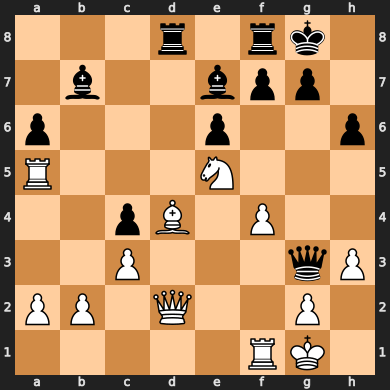

In [43]:
original_board = chess.Board(FEN)
original_board

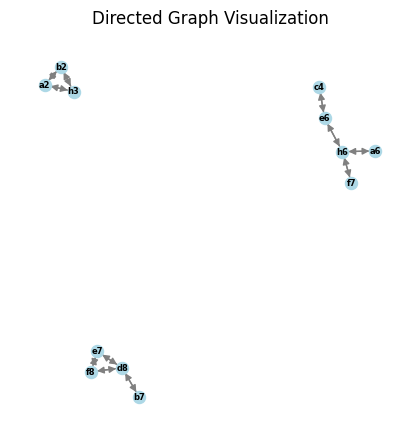

------------===============------------===============




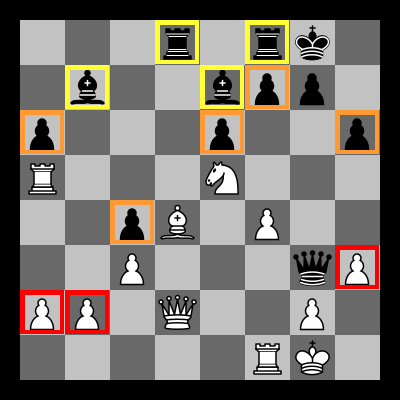



------------===============------------===============


In [53]:
most_related_pairs = filter_pairwise_sensitivity(pairwise_sensitivity, use_percentile=use_percentile, use_topk=use_topk, percentile=percentile, topk=topk)

important_groups = find_groups_important_relationships(most_related_pairs)
visualize_related_groups(original_board, important_groups)